In [2]:
%matplotlib inline

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.integrate import quad, cumtrapz
from tqdm import tqdm

import matplotlib as mpl
mpl.rcParams['font.size'] = 18.0

In [4]:
G_N = 4.302e-3

In [5]:
c = 100

def f_NFW(x):
    return np.log(1+x) - x/(1+x)

In [6]:
rho_AMC = 1.0
R_AMC = 1.0
r_s = R_AMC/c

x2_avg = 0.13*R_AMC**2

M_AMC = 4*np.pi*rho_AMC*(r_s)**3*f_NFW(c)
print(M_AMC)

psi0 = G_N*M_AMC/R_AMC

4.555336374123422e-05


### Quick summary of properties:

$$E_\mathrm{bind} \equiv \alpha \frac{G_N M_\mathrm{AMC}^2}{R_\mathrm{AMC}}$$

$$\langle R^2 \rangle = \kappa R_\mathrm{AMC}^2$$

**Power-law**: $\alpha = 3/2$, $\kappa = 3/11$

**NFW**: $\alpha = 3.46$, $\kappa = 0.133$

### Comparison of density profiles

**Power law** density profile:

$$\rho_\mathrm{PL}(r) = A/r^{9/4}$$

truncated at

$$R_\mathrm{AMC} = \left(\frac{3 M_\mathrm{AMC}}{4 \pi \rho_\mathrm{AMC}}\right)^{1/3}$$

meaning that the average density inside the minicluster is fixed equal to $\rho_\mathrm{AMC}$. The enclosed mass is given by:

$$M_\mathrm{enc}(r) = \frac{16\pi}{3} A r^{3/4} = M_\mathrm{AMC} \left(\frac{r}{R_\mathrm{AMC}}\right)^{3/4}$$

Or, put another way:

$$ \rho_\mathrm{PL}(r) = \frac{3 M_\mathrm{AMC}}{16 \pi R_\mathrm{AMC}{}^3} \left(\frac{R_\mathrm{AMC}}{r}\right)^{9/4} = \frac{\rho_\mathrm{AMC}}{4} \left(\frac{R_\mathrm{AMC}}{r}\right)^{9/4}$$

**NFW** density profile:

$$ \rho_\mathrm{NFW}(x) = \frac{\rho_s}{x(1+x)^2} \equiv \rho_s \omega(x)$$

where $x = r/r_s$ and the profile is truncated at $R_\mathrm{AMC} = c r_s$, with $c = 100$. We make the identification $\rho_s = \rho_\mathrm{AMC}$ and 

$$r_s = \left(\frac{M_\mathrm{AMC}}{4 \pi \rho_\mathrm{AMC} f_\mathrm{NFW}(c)}\right)^{1/3}$$


### NFW disruption


Potential:

$$\psi(r) = 4\pi G \rho_s r_s^2 \frac{\log(1 + x)}{x} = \frac{G_N M_\mathrm{AMC}}{R_\mathrm{AMC}} \frac{c}{f(c)} \frac{\log(1 + x)}{x}$$

**Binding energy:**

In [7]:
def psi_NFW(r):
    x = r/r_s
    return (G_N*M_AMC/R_AMC)*(c/f_NFW(c))*np.log(1+x)/x

def psi(r):
    psi_outer = G_N*M_AMC/np.clip(r, R_AMC, 1e30)
    return np.clip(psi_NFW(r) - psi_NFW(R_AMC), 0, 1e30) + psi_outer

@np.vectorize
def rho(r):
    x = r/r_s
    #if (x > c):
    #    return 0
    #else:
    return rho_AMC/(x*(1+x)**2)

In [8]:
print(quad(lambda x: rho(x)*4*np.pi*x**2, 0, 1)[0])

4.555336374113936e-05


In [9]:
R_list = np.geomspace(1e-6, 1e3, 1000)*R_AMC
rho_list = rho(R_list)
psi_list = psi(R_list)

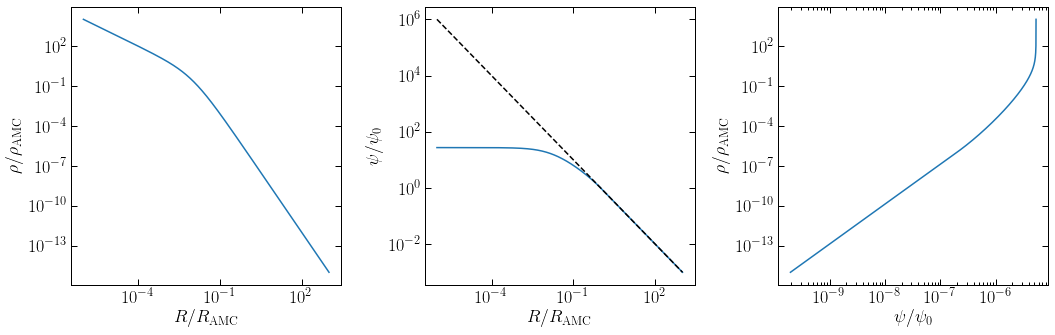

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].loglog(R_list, rho_list)
axes[0].set_xlabel(r"$R/R_\mathrm{AMC}$")
axes[0].set_ylabel(r"$\rho/\rho_\mathrm{AMC}$")

axes[1].loglog(R_list, psi_list/psi0)
axes[1].loglog(R_list, (G_N*M_AMC/R_list)/psi0, 'k--')
axes[1].set_xlabel(r"$R/R_\mathrm{AMC}$")
axes[1].set_ylabel(r"$\psi/\psi_0$")

axes[2].loglog(psi_list, rho_list)
axes[2].set_xlabel(r"$\psi/\psi_0$")
axes[2].set_ylabel(r"$\rho/\rho_\mathrm{AMC}$")

plt.tight_layout()

plt.show()

#### Generating the distribution function

In [11]:
rho_of_psi = interpolate.InterpolatedUnivariateSpline(psi_list[::-1], rho_list[::-1])
d2rho = rho_of_psi.derivative(n=2)

In [12]:
def f(eps):
    integ = lambda x: d2rho(x)/(np.sqrt(eps - x))
    result = quad(integ, 0, eps, epsrel=1e-6)[0]
    return result/(np.sqrt(8)*np.pi**2) 

In [13]:
eps_list = psi(R_list)

In [14]:
f_list = 0.0*eps_list
for i, eps in enumerate(tqdm(eps_list)):
    f_list[i] = f(eps)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  This is separate from the ipykernel package so we can avoid doing imports until
  1%|▏         | 14/1000 [00:00<00:23, 42.72it/s]/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perh

In [15]:
f_interp_NFW = interpolate.interp1d(eps_list, f_list, bounds_error=False, fill_value = 0.0)

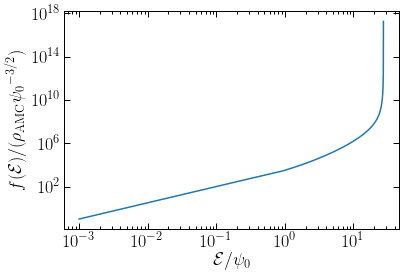

In [16]:
plt.figure()

plt.loglog(eps_list/psi0, f_list)

plt.xlabel(r"$\mathcal{E}/\psi_0$")
plt.ylabel(r"$f(\mathcal{E})/(\rho_\mathrm{AMC}\psi_0{}^{-3/2})$")

plt.show()

In [17]:
def v_max(r):
    return np.sqrt(2*psi(r))

def get_density(r):
    v_max = np.sqrt(2*psi(r))
    v_list = np.linspace(0, v_max, 100)
    f_list = f_interp_NFW(psi(r)-0.5*v_list**2)
    return 4*np.pi*np.trapz(v_list**2*f_list, v_list)

In [18]:
r_check = np.geomspace(1e-5, 1e3, 1000)
dens_list = 0.0*r_check

for i, r in enumerate(tqdm(r_check)):
    dens_list[i] = get_density(r)

100%|██████████| 1000/1000 [00:00<00:00, 6942.81it/s]


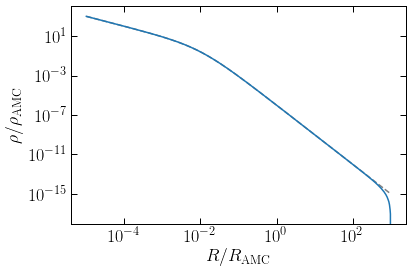

In [19]:
plt.figure()

plt.loglog(r_check, rho(r_check), linestyle='--', color='grey')
plt.loglog(r_check, dens_list)
#plt.xlim(0, 10)
plt.xlabel(r"$R/R_\mathrm{AMC}$")
plt.ylabel(r"$\rho/\rho_\mathrm{AMC}$")
plt.show()

#### Checking the AMC properties

**Total Mass**

In [20]:
def I_nocut(x):
    integ = lambda eps: np.sqrt(2*(psi(x) - eps))*f_interp_NFW(eps)
    return quad(integ, 0,  psi(x), epsrel=1e-4)[0]

def calcMass():
    x_range = np.geomspace(1e-6, 1, 100)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_nocut(x)
    return 16*np.pi**2*np.trapz(I_integ*x_range**2, x_range)

In [21]:
M_total = calcMass()
print(M_total/M_AMC)

/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  This is separate from the ipykernel package so we can avoid doing imports until


1.002099844881147


**Kinetic Energy**

In [22]:
def I_kin(x):
    integ = lambda eps: 0.5*(np.sqrt(2*(psi(x) - eps)))**3*f_interp_NFW(eps)
    return quad(integ, 0, psi(x), epsrel=1e-4)[0]

def calcEkin():
    x_range = np.geomspace(1e-6, 1, 100)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_kin(x)
    return 16*np.pi**2*np.trapz(I_integ*x_range**2, x_range)

In [23]:
E_kin = calcEkin()
kappa = 2*E_kin/(G_N*M_AMC**2/R_AMC)
print("kappa = ", kappa)

kappa =  3.5353707100176943


**Potential Energy**

In [24]:
#Note the factor of 1/2 to prevent double-counting.
def I_pot(x):
    integ = lambda eps: 0.5*psi(x)*np.sqrt(2*(psi(x) - eps))*f_interp_NFW(eps)
    return quad(integ, 0, psi(x), epsrel=1e-4)[0]

def calcEpot():
    x_range = np.geomspace(1e-6, 1, 100)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_pot(x)
    return 16*np.pi**2*np.trapz(I_integ*x_range**2, x_range)

In [25]:
E_bind = calcEpot()
beta = E_bind/(G_N*M_AMC**2/R_AMC)
print("beta = ", beta)

/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  after removing the cwd from sys.path.
/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  after removing the cwd from sys.path.


beta =  3.4679092858320346


In [26]:
E_total = E_kin - E_bind
print(E_total/(G_N*M_AMC**2/R_AMC))

-1.7002239308231877


#### Mass Loss

The total mass is then:

$$ M(< \Delta \eta) = 16\pi^2 \rho_\mathrm{AMC}  R_\mathrm{AMC}^3 \int_{0}^{1} x^2 I(y, \Delta \eta)\,\mathrm{d}y$$

Although actually, note that $\Delta \mathcal{E} = (\Delta E/M) \times r^2/\langle r^2 \rangle$

In [36]:
def I_loss(x, delta_eps):
    integ = lambda eps: np.sqrt(2*(psi(x) - eps))*f_interp_NFW(eps)
    return quad(integ, 0, np.minimum(delta_eps, psi(x)), epsrel=1e-4)[0]

def I_remain(x, delta_eps):
    integ = lambda eps: np.sqrt(2*(psi(x) - eps))*f_interp_NFW(eps)
    return quad(integ, np.minimum(delta_eps, psi(x)), psi(x), epsrel=1e-4)[0]

def calcMassLoss(delta_eps):
    x_range = np.geomspace(1e-6, 1, 100)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_loss(x, delta_eps*x**2/x2_avg)
    return 16*np.pi**2*np.trapz(I_integ*x_range**2, x_range)

In [29]:
deltaE_list = np.geomspace(1e-6, 1e4, 200)*E_bind

In [30]:
deltaM_list = 0.0*deltaE_list

for i, deltaE in enumerate(tqdm(deltaE_list)):
    deltaM_list[i] = calcMassLoss(deltaE/M_AMC)

100%|██████████| 200/200 [00:42<00:00,  4.71it/s]


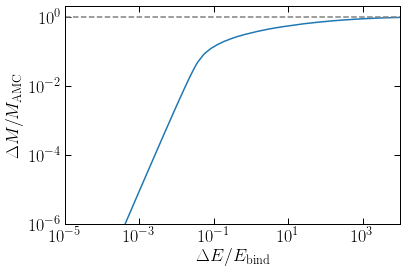

In [31]:
plt.figure()
plt.loglog(deltaE_list/E_bind, deltaM_list/M_AMC)

plt.xlim(1e-5, 1e4)
plt.ylim(1e-6, 2)

plt.xlabel(r"$\Delta E/E_\mathrm{bind}$")
plt.ylabel(r"$\Delta M/M_\mathrm{AMC}$")

plt.axhline(1.0, linestyle='--', color='grey')
plt.show()

#### Energy Ejection and Remaining

In [32]:
def calcEnergyEjected(delta_eps):
    x_range = np.geomspace(1e-6, 1, 100)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_loss(x, delta_eps*x**2/x2_avg)
    return 16*np.pi**2*np.trapz((delta_eps*x_range**2/x2_avg)*I_integ*x_range**2, x_range)

In [33]:
E_ejec_list = 0.0*deltaE_list
for i, deltaE in enumerate(tqdm(deltaE_list)):
    E_ejec_list[i] = calcEnergyEjected(deltaE/M_AMC)

100%|██████████| 200/200 [00:37<00:00,  5.40it/s]


In [37]:
def calcEnergyRemain(delta_eps):
    x_range = np.geomspace(1e-6, 1, 100)
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_remain(x, delta_eps*x**2/x2_avg)
    return 16*np.pi**2*np.trapz((delta_eps*x_range**2/x2_avg)*I_integ*x_range**2, x_range)

In [38]:
E_rem_list = 0.0*deltaE_list
for i, deltaE in enumerate(tqdm(deltaE_list)):
    E_rem_list[i] = calcEnergyRemain(deltaE/M_AMC)


  0%|          | 0/200 [00:00<?, ?it/s]/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys
/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  import sys

  0%|          | 1/200 [00:03<11:24,  3.44s/it]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/Users/bradkav/anaconda3/lib/pyth

In [47]:
f_ej_list = E_ejec_list/deltaE_list
f_rem_list = E_rem_list/deltaE_list
f_ej_fixed = np.append(f_ej_list[:100], 1-f_rem_list[100:]) #Fix numerical issues when f_ej is close to 0 or 1

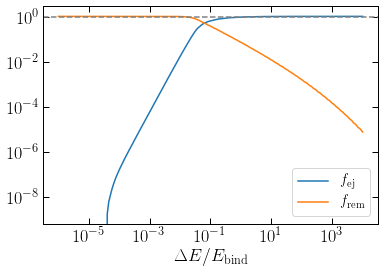

In [40]:
plt.figure()

plt.loglog(deltaE_list/E_bind, f_ej_list, label=r'$f_\mathrm{ej}$')
plt.loglog(deltaE_list/E_bind, f_rem_list, label=r'$f_\mathrm{rem}$')
plt.xlabel(r"$\Delta E/E_\mathrm{bind}$")
#plt.ylabel(r"$f_\mathrm{rem}$")

plt.legend(loc='best')

plt.axhline(1.0, linestyle='--', color='grey')

plt.show()

#### Initial Energy of unbound particles

We'll define the 'initial energy of the particles which will eventually be unbound' as:
$$E_i^\mathrm{unbound} = T_i^\mathrm{unbound} + E_{\mathrm{bind}, i} - E_{\mathrm{bind}, f}$$
where $T_i^\mathrm{unbound}$ is the total initial kinetic energy of the particles which will be unbound.

In [41]:
def calcFinalEbind(delta_eps):
    x_range = np.geomspace(1e-6, 1, 100)
    rho_final = 0.0*x_range
    for j, x in enumerate(x_range):
        rho_final[j] = 4*np.pi*I_remain(x, delta_eps*x**2/x2_avg)
    Menc = cumtrapz(4*np.pi*rho_final*x_range**2, x_range, initial=0.0)
    return G_N*np.trapz((Menc/x_range)*4*np.pi*rho_final*x_range**2, x_range)

In [42]:
def I_kin_loss(x, delta_eps):
    integ = lambda eps: 0.5*(np.sqrt(2*(psi(x) - eps)))**3*f_interp_NFW(eps)
    return quad(integ, 0, np.minimum(delta_eps, psi(x)), epsrel=1e-4)[0]

def calcEunbound_kin(delta_eps):
    x_range = np.geomspace(1e-6, 1, 100)*R_AMC
    I_integ = 0.0*x_range
    for j, x in enumerate(x_range):
        I_integ[j] = I_kin_loss(x, delta_eps*x**2/x2_avg)
    return 16*np.pi**2*np.trapz(I_integ*x_range**2, x_range)

In [45]:
deltaU0 = -calcFinalEbind(0)- (-E_bind)
#print(FinalEbind0)
def calcEi_unbound(deltaE):
    T_i_ub = calcEunbound_kin(deltaE/M_AMC)
    deltaU = (-calcFinalEbind(deltaE/M_AMC)) - (-E_bind) - deltaU0
    #print(deltaU)
    return T_i_ub - (deltaU)

/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys
/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  import sys


In [46]:
Ei_unbound_list = 0.0*deltaE_list
for i, deltaE in enumerate(tqdm(deltaE_list)):
    Ei_unbound_list[i] = calcEi_unbound(deltaE)

  0%|          | 0/200 [00:00<?, ?it/s]/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys
/Users/bradkav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  import sys
100%|██████████| 200/200 [10:17<00:00,  3.09s/it]


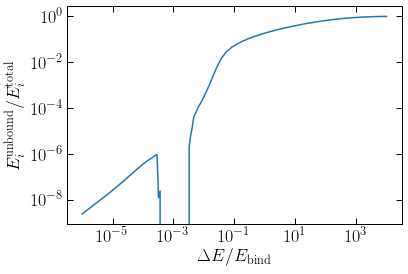

In [48]:
plt.figure()

plt.loglog(deltaE_list/E_bind, Ei_unbound_list/E_total)

plt.xlabel(r"$\Delta E/E_\mathrm{bind}$")
plt.ylabel(r"$E_i^\mathrm{unbound}/E_i^\mathrm{total}$")

plt.show()

In [50]:
E_final_list = E_total + deltaE_list*(1 - f_ej_fixed) -  Ei_unbound_list

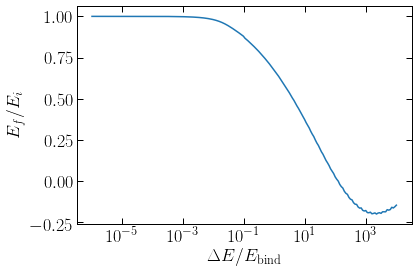

In [51]:
plt.figure()

plt.semilogx(deltaE_list/E_bind, E_final_list/E_total)

plt.xlabel(r"$\Delta E/E_\mathrm{bind}$")
plt.ylabel(r"$E_f/E_i$")

plt.show()

#### Summary plot

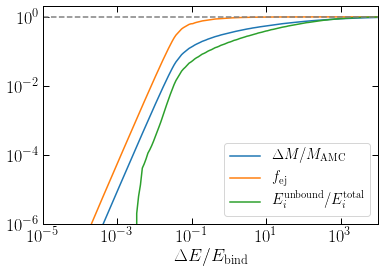

In [53]:
plt.figure()

plt.loglog(deltaE_list/E_bind, deltaM_list/M_AMC, label="$\Delta M/M_\mathrm{AMC}$")

plt.loglog(deltaE_list/E_bind, f_ej_fixed, label="$f_\mathrm{ej}$")

plt.loglog(deltaE_list/E_bind, Ei_unbound_list/E_total, label="$E_i^\mathrm{unbound}/E_i^\mathrm{total}$")

plt.axhline(1.0, linestyle='--', color='grey')

plt.xlabel(r"$\Delta E/E_\mathrm{bind}$")
#plt.ylabel(r"$E_i^\mathrm{unbound}/E_i^\mathrm{total}$")

plt.xlim(1e-5, 1e4)
plt.ylim(1e-6, 2)

plt.legend(loc='best')

plt.show()

In [54]:
hdrtxt = "Binding energy = (3.46)*G_N*M_AMC^2/R_AMC\nColumns: deltaE/Ebind, deltaM/M, f_ej, E_i_unbound/E_i_total"

np.savetxt("../data/Perturbations_NFW.txt", list(zip(deltaE_list/E_bind, deltaM_list/M_AMC, f_ej_fixed, np.clip(Ei_unbound_list/E_total, 0, 1e30))), header=hdrtxt)

In [61]:
E_final_check = E_total + deltaE_list*(1-f_ej_fixed) - np.clip(Ei_unbound_list/E_total, 0, 1e30)*E_total

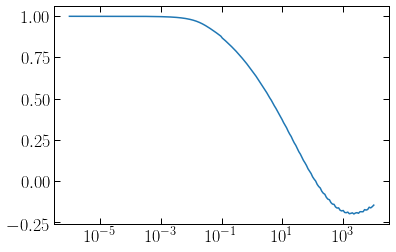

In [62]:
plt.figure()

plt.semilogx(deltaE_list/E_bind, E_final_check/E_total)

plt.show()